# Automatic Differentiation

:label:`chapter_autograd`


In machine learning, we *train* models, updating them successively so that they get better and better as they see more and more data. Usually, *getting better* means minimizing a *loss function*, a score that answers the question "how *bad* is our model?" With neural networks, we typically choose loss functions that are differentiable with respect to our parameters.
Put simply, this means that for each of the model's parameters, we can determine how much *increasing* or *decreasing* it might affect the loss. While the calculations for taking these derivatives are straightforward, requiring only some basic calculus, for complex models, working out the updates by hand can be a pain (and often error-prone).

The autograd package expedites this work by automatically calculating derivatives. And while many other libraries require that we compile a symbolic graph to take automatic derivatives, `autograd` allows us to take derivatives while writing  ordinary imperative code. Every time we pass data through our model, `autograd` builds a graph on the fly, tracking which data combined through which operations to produce the output. This graph enables `autograd` to subsequently backpropagate gradients on command. Here *backpropagate* simply means to trace through the compute graph, filling in the partial derivatives with respect to each parameter. If you are unfamiliar with some of the math, e.g. gradients, please refer to :numref:`chapter_math`.

In [1]:
from mxnet import autograd, nd

## A Simple Example

As a toy example, say that we are interested in differentiating the mapping $y = 2\mathbf{x}^{\top}\mathbf{x}$ with respect to the column vector $\mathbf{x}$. To start, let's create the variable `x` and assign it an initial value.

In [2]:
x = nd.arange(4)
x


[0. 1. 2. 3.]
<NDArray 4 @cpu(0)>

Once we compute the gradient of ``y`` with respect to ``x``, we will need a place to store it. We can tell an NDArray that we plan to store a gradient by invoking its ``attach_grad()`` method.

In [3]:
x.attach_grad()

Now we are going to compute ``y`` and MXNet will generate a computation graph on the fly. It is as if MXNet turned on a recording device and captured the exact path by which each variable was generated.

Note that building the computation graph requires a nontrivial amount of computation. So MXNet will only build the graph when explicitly told to do so. This happens by placing code inside a ``with autograd.record():`` block.

In [4]:
with autograd.record():
    y = 2 * nd.dot(x, x)
y


[28.]
<NDArray 1 @cpu(0)>

Since `x` is a vector of length 4, `nd.dot` will perform inner product and
therefore `y` is a scalar. Next, we can automatically
find the gradient of all the inputs by calling the `backward` function.

In [5]:
y.backward()

The gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$ with respect to $\mathbf{x}$ should be $4\mathbf{x}$. Now let's verify that the gradient produced is correct.

In [6]:
x.grad - 4 * x


[0. 0. 0. 0.]
<NDArray 4 @cpu(0)>

If $x$ is used in another computation to compute the gradient, previous `x.grad` contents will be overwritten.

In [7]:
with autograd.record():
    y = x.norm()
y.backward()
x.grad


[0.         0.26726124 0.5345225  0.80178374]
<NDArray 4 @cpu(0)>

## Backward for Non-scalar Variable

When `y` is not a scalar, the gradients could be high order tensor and complex
to compute (refer to :numref:`chapter_math`). In both machine learning and deep
learning, luckily we only compute gradients for loss functions, whose values are
often scalars.  So MXNet will sum the elements in `y` to get the new variable by
default, and then find the analytical gradient of the variable with respect to
`x` evaluated at its current value $\frac{dy}{dx}$.

In [8]:
with autograd.record():  # y is a vector
    y = x * x
y.backward()

u = x.copy()
u.attach_grad()
with autograd.record():  # v is scalar
    v = (u * u).sum()
v.backward()

x.grad - u.grad


[0. 0. 0. 0.]
<NDArray 4 @cpu(0)>

## Detach Computations

We could move some parts of computations out of the computation graph. Assume $y=f(x)$ and $z=g(y)$. Then `u = y.detach()` will return a new variable has the same values as $y$ but forgets how $u$ is computed. It equals to compute $u=f(x)$ not within a `autograd.record` scope, namely $u$ is treated as constant. The following backward computes $\partial u^2 x/\partial x$ with $u=x$ instead of $\partial x^3/\partial x$.

In [9]:
with autograd.record():
    y = x * x
    u = y.detach()
    z = u * x
z.backward()
x.grad - u


[0. 0. 0. 0.]
<NDArray 4 @cpu(0)>

Since the computation of $y$ is still recorded, we can call `y.backward()` to get $\partial y/\partial x = 2x$.

In [10]:
y.backward()
x.grad - 2*x


[0. 0. 0. 0.]
<NDArray 4 @cpu(0)>

## Attach Gradients to Internal Variables

Attaching gradients to a variable `x` implicitly calls `x=x.detach()`. If `x` is computed based on other variables, this part of computation will not be used in the backward function.

In [11]:
y = nd.ones(4) * 2
y.attach_grad()
with autograd.record():
    u = x * y
    u.attach_grad()  # implicitly run u = u.detach()
    z = u + x
z.backward()
x.grad, u.grad, y.grad

(
 [1. 1. 1. 1.]
 <NDArray 4 @cpu(0)>, 
 [1. 1. 1. 1.]
 <NDArray 4 @cpu(0)>, 
 [0. 0. 0. 0.]
 <NDArray 4 @cpu(0)>)

## Head gradients

Detaching allows to breaks the computation into several parts. We could use chain rule :numref:`chapter_math` to compute the gradient for the whole computation.  Assume $u = f(x)$ and $z = g(u)$, by chain rule we have $\frac{dz}{dx} = \frac{dz}{du} \frac{du}{dx}.$ To compute $\frac{dz}{du}$, we can first detach $u$ from the computation and then call `z.backward()` to compute the first term.

In [12]:
y = nd.ones(4) * 2
y.attach_grad()
with autograd.record():
    u = x * y
    v = u.detach()  # u still keeps the computation graph
    v.attach_grad()
    z = v + x
z.backward()
x.grad, y.grad

(
 [1. 1. 1. 1.]
 <NDArray 4 @cpu(0)>, 
 [0. 0. 0. 0.]
 <NDArray 4 @cpu(0)>)

Later on we call `u.backward()` to compute the second term, but pass the first term as the head gradients to multiply both terms so that `x.grad` will contains $\frac{dz}{dx}$ instead of $\frac{du}{dx}$.

In [13]:
u.backward(v.grad)
x.grad, y.grad

(
 [2. 2. 2. 2.]
 <NDArray 4 @cpu(0)>, 
 [0. 1. 2. 3.]
 <NDArray 4 @cpu(0)>)

## Computing the Gradient of Python Control Flow

One benefit of using automatic differentiation is that even if the computational graph of the function contains Python's control flow (such as conditional and loop control), we may still be able to find the gradient of a variable. Consider the following program:  It should be emphasized that the number of iterations of the loop (while loop) and the execution of the conditional statement (if statement) depend on the value of the input `b`.

In [14]:
def f(a):
    b = a * 2
    while b.norm().asscalar() < 1000:
        b = b * 2
    if b.sum().asscalar() > 0:
        c = b
    else:
        c = 100 * b
    return c

Note that the number of iterations of the while loop and the execution of the conditional statement (if then else) depend on the value of `a`. To compute gradients, we need to `record` the calculation, and then call the `backward` function to calculate the gradient.

In [15]:
a = nd.random.normal(shape=1)
a.attach_grad()
with autograd.record():
    d = f(a)
d.backward()

Let's analyze the `f` function defined above. As you can see, it is piecewise linear in its input `a`. In other words, for any `a` there exists some constant such that for a given range `f(a) = g * a`. Consequently `d / a` allows us to verify that the gradient is correct:

In [16]:
print(a.grad == (d / a))


[1.]
<NDArray 1 @cpu(0)>


## Training Mode and Prediction Mode

As you can see from the above, after calling the `record` function, MXNet will
record the operations and calculate the gradient. In addition, `autograd` will
also change the running mode from the prediction mode to the training mode by
default. This can be viewed by calling the `is_training` function.

In [17]:
print(autograd.is_training())
with autograd.record():
    print(autograd.is_training())

False
True


In some cases, the same model behaves differently in the training and prediction modes (e.g. when using neural techniques such as dropout :numref:`chapter_dropout` and batch normalization :numref:`chapter_batch_norm`). In other cases, some models may store more auxiliary variables to make computing gradients easier. We will cover these differences in detail in later chapters. For now, you do not need to worry about them.


## Summary

* MXNet provides an `autograd` package to automate the derivation process. To do so, we first attach gradients to variables, record the computation, and then run the backward function.
* We can detach gradients and pass head gradients to the backward function to control the part of the computation will be used in the backward function.
* The running modes of MXNet include the training mode and the prediction mode. We can determine the running mode by `autograd.is_training()`.

## Exercises

1. Try to run `y.backward()` twice.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or matrix. At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Redesign an example of finding the gradient of the control flow. Run and analyze the result.
1. In a second-price auction (such as in eBay or in computational advertising), the winning bidder pays the second-highest price. Compute the gradient of the final price with respect to the winning bidder's bid using `autograd`. What does the result tell you about the mechanism? If you are curious to learn more about second-price auctions, check out this paper by [Edelman, Ostrovski and Schwartz, 2005](https://www.benedelman.org/publications/gsp-060801.pdf).
1. Why is the second derivative much more expensive to compute than the first derivative?
1. Derive the head gradient relationship for the chain rule. If you get stuck, use the ["Chain rule" article on Wikipedia](https://en.wikipedia.org/wiki/Chain_rule).
1. Assume $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$ on a graph, where you computed the latter without any symbolic calculations, i.e. without exploiting that $f'(x) = \cos(x)$.

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2318)

![](../img/qr_autograd.svg)

In [14]:
#1
x = nd.arange(4)

x.attach_grad()

with autograd.record():
    y = x * x * x
    
y.backward()
x.grad

# cannot run the second time 


[ 0.  3. 12. 27.]
<NDArray 4 @cpu(0)>

In [18]:
#2
def f(a):
    b = a * 2
    while b.norm().asscalar() < 1000:
        b = b * 2
    if b.sum().asscalar() > 0:
        c = b
    else:
        c = 100 * b
    return c


a = nd.random.randint(1, 2, shape=(4,))
a.attach_grad()
with autograd.record():
    d = f(a)
d.backward()

print(a.grad == (d / a))


# the result will be a vector 


[1 1 1 1]
<NDArray 4 @cpu(0)>


In [21]:
#3 
def f2(a):
    if a.sum().asscalar() > 0 :
        b = 5 * a * a
    else:
        b = 10 * a
    return b 

a = nd.random.randint(1, 2, shape=(4,))
a.attach_grad()
with autograd.record():
    c = f2(a)

c.backward()
print(a.grad)
print(a)


[10 10 10 10]
<NDArray 4 @cpu(0)>

[1 1 1 1]
<NDArray 4 @cpu(0)>


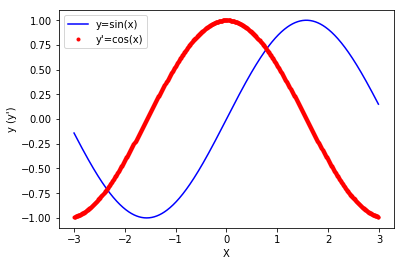

In [33]:
#7
import matplotlib.pyplot as plt 

x = nd.arange(-3, 3, step=0.01)
y = nd.sin(x)

x.attach_grad()
with autograd.record():
    y = nd.sin(x)
    
y.backward()
y2 = x.grad

plt.plot(x.asnumpy(), y.asnumpy(), "b-", label="y=sin(x)")
plt.plot(x.asnumpy(), y2.asnumpy(), "r.", label="y'=cos(x)")
plt.legend()
plt.xlabel("X")
plt.ylabel("y (y')")
plt.show()
